# Using the msl_cg library within Jupyter

Let's simulate a diffusion process:

\begin{equation*}
\left\lbrace
\begin{aligned}
-\nabla\cdot(\kappa \nabla u) & = f \text{ in }\,\Omega\,,\\
u & = 0 \text{ on } \partial\Omega  
\end{aligned}
\right. 
\end{equation*}

using the Galerkin method, observing how the use of increasingly finer meshes improves the results. But, first:

**Mind that, for the code below to work smoothly, the directories `results_3`, `results_4`, `results_5`, and `results_6` must exist in the root of this Jupyter notebook!**

In [1]:
import os

for x in range(3, 7):
    path = "results_" + str(x)
    try:
        os.mkdir(path)
    except OSError:
        print ("Creation of the directory %s failed (already exists, perhaps?)" % path)
    else:
        print ("Successfully created the directory %s " % path)

Successfully created the directory results_3 
Successfully created the directory results_4 
Successfully created the directory results_5 
Successfully created the directory results_6 


Now we're ready to proceed do C++. As always, you first need to setup the location of the include and library files:

In [1]:
#pragma cling add_library_path("/usr/local/lib/")

#pragma cling add_include_path("/usr/local/include/")
#pragma cling add_include_path("/usr/local/include/msl_core/")
#pragma cling add_include_path("/usr/local/include/msl_core/third_party/")
#pragma cling add_include_path("/usr/local/include/msl_cg/")

#pragma cling load("libeasyloggingpp.so")
#pragma cling load("libtriangle.so")
#pragma cling load("libtetgen.so")
#pragma cling load("libmsl_core.so")
#pragma cling load("libmsl_cg.so")

After that, just `#include` the relevant header files and throw your code! 

**One important observation before going on**: since we're running in C++ interpreted mode here, we don't use the notion of other separate modules than the MSL libraries. Therefore, the module that implements the Galerkin formulation (file `problem_cgdiffusion.cpp`) is "included" just like any header file, instead of the actual header file `problem_cgdiffusion.h`. Both files are provided as examples in this notebook.

In [2]:
#include <cmath>

#include "LinearSystem/linear_system.h"

//Yeah, it's cpp indeed, to avoid compiling this module separatedly out of the notebook
#include "problem_cgdiffusion.cpp"

In [3]:
MSL_configure_easyloggingpp();

{
    std::ofstream conv_data_cg;
    conv_data_cg.open("conv_data_cg.txt");
    
    for (int H=3; H<7; ++H)
    {
        //! [Creating a problem]
        std::shared_ptr<DiffusionCGProblem> problem = std::make_shared<DiffusionCGProblem>();

        int iPk = 1;
        problem->setPkList({iPk});

        std::string path_mesh = "test_data";
        std::string name_mesh = "ccross";
        int index_mesh = H;
        problem->setPathMesh(path_mesh);
        problem->setNameMesh(name_mesh);
        problem->setIndexMesh(index_mesh);
        mesh_reader::MeshComponents what_to_read = mesh_reader::NODE|mesh_reader::ELEM;
        if (iPk > 1) { 
            what_to_read |= mesh_reader::EDGE;
            if (problem->getMeshDim() == 2)
                what_to_read |= mesh_reader::NEIG;
        }
        if (iPk > 2 && problem->getMeshDim() == 3)
            what_to_read |= mesh_reader::FACE|mesh_reader::NEIG;
        problem->buildMesh(what_to_read);

        std::string path_data = "test_data";
        std::string data_file = "physics_diffusion_2d_with_u";
        problem->setPathData(path_data);
        problem->readDataFiles({data_file});

        if (H==3)
            problem->printData();

        problem->configureSpaces();
        problem->buildVariationalForm();
        //! [Creating a problem]

        //! [Solving a problem]
        problem->solve();
        //! [Solving a problem]

        //! [Printing a problem solution]
        std::string path_output_mesh = "results_";
        path_output_mesh += std::to_string(H);
        problem->printMeshWithHeaders(
                    path_output_mesh,
                    "facade_output");
        problem->appendResultsToMesh();
        //! [Printing a problem solution]

        //! [Computing problem errors]
        MSL_FP_TYPE eL2 = problem->computeError("L2");
        MSL_FP_TYPE eSemiH1 = problem->computeError("semiH1");
        MSL_FP_TYPE eH1 = sqrt(eL2*eL2+eSemiH1*eSemiH1);

        LOG(INFO) << "=== mesh ccross " << H;
        LOG(INFO) << "L2-norm error: " << eL2;
        LOG(INFO) << "H1-norm error: " << eH1;
        
        conv_data_cg << H << " " << eL2 << " " << eH1 << std::endl;
        //! [Computing problem errors]
    }
    
    conv_data_cg.close();
}

2023-02-08 10:04:10,661 [INFO] **************************    DATA    ******************************

diffusion = {
    kappa = 1.0, 
    --
    f     = "8*pi*pi * math.sin(2*pi*x) * math.sin(2*pi*y)",
    --
    u     = "math.sin(2*pi*x)*math.sin(2*pi*y)",
    --
    du    = "{2*pi*math.cos(2*pi*x)*math.sin(2*pi*y),2*pi*math.sin(2*pi*x)*math.cos(2*pi*y)}",
    --
    q     = "{-2*pi*math.cos(2*pi*x)*math.sin(2*pi*y),-2*pi*math.sin(2*pi*x)*math.cos(2*pi*y)}",
    --
    f_iOrder = 4,
    u_iOrder = 4,
    du_iOrder = 4,
    q_iOrder = 4,
    --
    g = {
        ["1"] = 0,
        ["2"] = 0,
        ["3"] = 0,
        ["4"] = 0,
        ["5"] = 0  --needed because of a bizarre behavior of Triangle mesh generator
    }
}


2023-02-08 10:04:10,662 [INFO] ********************     END OF DATA   *****************************

2023-02-08 10:04:10,789 [INFO] === mesh ccross 3
2023-02-08 10:04:10,789 [INFO] L2-norm error: 0.0978689
2023-02-08 10:04:10,790 [INFO] H1-norm error: 1.83046
2023-02-0

Let's save the data in tar file so you can easily "download" the results and visualize them in Paraview...

In [4]:
!tar zcvf results_cg.tar.gz results_*

results_3/
results_3/facade_output.geo
results_3/solution.nsca
results_3/facade_output.case
results_4/
results_4/facade_output.geo
results_4/solution.nsca
results_4/facade_output.case
results_5/
results_5/facade_output.geo
results_5/solution.nsca
results_5/facade_output.case
results_6/
results_6/facade_output.geo
results_6/solution.nsca
results_6/facade_output.case


Let's now get back to Python and plot some convergence curves....

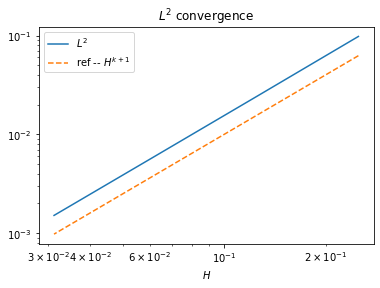

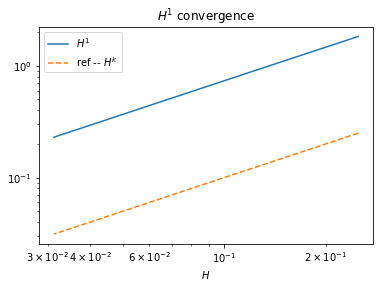

In [4]:
import matplotlib.pyplot as plt

# Load the data from the file into three arrays
H, eL2, eH1 = [], [], []
with open('conv_data_cg.txt', 'r') as file:
    for line in file:
        values = line.split()
        H.append(1.0/(pow(2,float(values[0])-1)))
        eL2.append(float(values[1]))
        eH1.append(float(values[2]))
        
k = 1
rL2 = [pow(i, k+1) for i in H]
        
plt.plot(H, eL2, label=r'$L^2$')
plt.plot(H, rL2, label=r'ref -- $H^{k+1}$', linestyle="dashed")
plt.xlabel(r'$H$')
plt.xscale('log')
plt.yscale('log')
plt.title(r'$L^2$ convergence')
plt.legend()
plt.show()

rH1 = [pow(i, k) for i in H]
        
plt.plot(H, eH1, label=r'$H^1$')
plt.plot(H, rH1, label=r'ref -- $H^{k}$', linestyle="dashed")
plt.xlabel(r'$H$')
plt.xscale('log')
plt.yscale('log')
plt.title(r'$H^1$ convergence')
plt.legend()
plt.show()